This is the part that sets up the images into k clusters for k means! In the other jupyter notebook I custom implemented the k means clustering for extra credit but I used the built in one here because it was faster!

In [67]:
import sklearn
import numpy as np
import scipy
import math
import os
import cv2
import math
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import time
from random import randint
import random
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.svm import SVC 

print ("now starting")

sift = cv2.xfeatures2d.SIFT_create()
mypicdict=[]

directory="Clustering"
for filename in os.listdir(directory):
    mypicdict.append(directory+"/"+filename)
        
mymatrix=np.zeros((0, 128))
start = time.time()
for pic in mypicdict:
    img1_ = cv2.imread(pic)
    img1= cv2.cvtColor(img1_,cv2.COLOR_BGR2GRAY)
    kp1, des1 = sift.detectAndCompute(img1,None)
    try:
        mymatrix=np.concatenate((mymatrix, des1[0:des1.shape[0]-1]),  axis=0) #this takes a while
    except Exception:
        print (Exception)
        continue
        
end = time.time()
print((end - start))
print ("is starting to make kmeans")
start=time.time()
kmeans = KMeans(n_clusters=100).fit(mymatrix)
end=time.time()
print((end - start))
print ("is done with kmeans!")




now starting
7.965710878372192
is starting to make kmeans
161.02727699279785
is done with kmeans!


So it seems that for this lab about 100 clusters was the best accuracy for most categories as you can see in the table below! (if its not showing up its the image in this folder)
![title](Cluster_Accuracy.png)  I ran this on the first 25 categories of the CalTech data set Perhaps for different data sets another number would be more optimal but at least for these categories 100 seemed to be the best. It also seemed in general that my accuracy was really struggling to improve above forty percent so perhaps if I ran with all the images in that data set this would improve more.  Unfortunately for me my computer was barely able to run the 25 data sets in a reasonable amount of time! On this data set also I used about 5 to cluster on from each class and half to train on and halt to test on and each class had about 50 in total to keep it evenly distibuted across each class.  


This is the code that I train the SVM's on!  An example of histogram is shown!

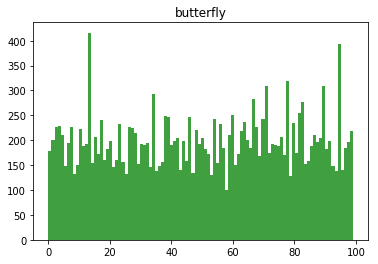

In [68]:
#Training
rootdir="101_ObjectCategories"
mysklearners=[]
mydirs=[]
firsttime=True
myhists=[]
for subdir, dirs, files in os.walk(rootdir):  
    myhist=[]
    mybarchart=[0]*100
    X=[]
    y=[]
    if firsttime==True:
        mydirs=dirs
        firsttime=False
        continue
    flag=True
    while flag==True:
        test=random.choice(mydirs)
        if os.listdir(rootdir+"/"+test)!=files:
            flag=False
    #print ("training on ", subdir)
    for file in files:
        if file != ".DS_Store":
            temp=os.path.join(subdir, file)
            imageToTest=cv2.imread(temp)
            img1= cv2.cvtColor(imageToTest,cv2.COLOR_BGR2GRAY)
            kp1, des1 = sift.detectAndCompute(img1,None)
            for x in range(des1.shape[0]):
                #print(kmeans.predict(np.asarray([des1[x]])))
                result=kmeans.predict(np.asarray([des1[x]]))[0]
                myhist.append(result)
                mybarchart[result]+=1
            myhists.append(myhist)    
            X.append(mybarchart)
            y.append(0)
            #break
    #print ("invalid data from ", test)        
    for file in os.listdir(rootdir+"/"+test):  
        if file != ".DS_Store":
            #print ("hello there",file)
            temp=rootdir+"/"+test+"/"+file
            imageToTest=cv2.imread(temp)
            img1= cv2.cvtColor(imageToTest,cv2.COLOR_BGR2GRAY)
            kp1, des1 = sift.detectAndCompute(img1,None)
            for x in range(des1.shape[0]):
                #print(kmeans.predict(np.asarray([des1[x]])))
                result=kmeans.predict(np.asarray([des1[x]]))[0]
                myhist.append(result)
                mybarchart[result]+=1    
            X.append(mybarchart)
            y.append(1)
            #break
    #print ("doing file ",  dirs)        
    model = SVC(kernel='linear', C=1E10, probability=True)
    X=np.asarray(X)
    y=np.asarray(y)
    #print (X.shape, y.shape)
    #print (y)
    if X.shape[0]==0:
        continue
    #print("predicting now")    
    model.fit(X, y)
    mysklearners.append(model)
    break
x=0

plt.title(mydirs[x])
#print (hist)
plt.hist(hist,  100, facecolor='g', alpha=0.75)
plt.show()    

As you can see in the code above I decided to run my lab on the SVM learner that was provided by sklearn!  As this was what was recommended on the spec and had documnetation,  this is what I decided to ultimatly run on my project!  I essentially made an svm for each folder/class that I trained both positive and negative instances of that image. I then below in my training would then test each svm to see which one produces the higest result. The one with the highest confidence would be the class I would decide it would be.   

This is where I run my testing on!

In [ ]:
rootdir="Testing"
x=0
from sklearn.metrics import average_precision_score
scores=[]
Y=[]
for subdir, dirs, files in os.walk(rootdir):  #loads my files into a dictionary
  for model in mysklearners:
    X=[]
    y=[]
    y2=[]
    if files==[]:
        continue
    for file in files:
    
        if file != ".DS_Store":
            myhist=[]
            mybarchart=[0]*100
            temp=os.path.join(subdir, file)
            imageToTest=cv2.imread(temp)
            img1= cv2.cvtColor(imageToTest,cv2.COLOR_BGR2GRAY)
            kp1, des1 = sift.detectAndCompute(img1,None)
            for x in range(des1.shape[0]):
                result=kmeans.predict(np.asarray([des1[x]]))[0]
                myhist.append(result)
                mybarchart[result]+=1        
            X.append(mybarchart)
            y.append(1)
            y.append(0)
            #break
        else:
            continue 
    if len(X)!=0:       
        #print (X)   
        yscores=model.predict_proba(X)
        #print (yscores.flatten('F'))
        #print (y+y2)        
        scores.append((average_precision_score(y+y2, yscores.flatten('F'))),subdir )      
        Y.append(y)
   


As you can see in the charts below there appears to be a great amount of flux between classes.  It appears that butterfly and crabs are able to be run a lot more accurately then airplanes. Looking through these pictures it makes sense as the airplanes are very diverse low quality pictures unlike the crabs or butterflies. As far as for different sized clusters again it seems that a couple of classes like chandeliers will improve if I decrease the number of clusters however this is more than offset by the decrease in accuracy to the butterfly classification svm.  The recall curve area is also described in the images shown below. 


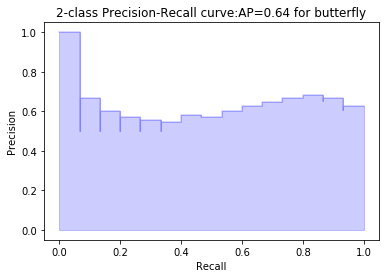

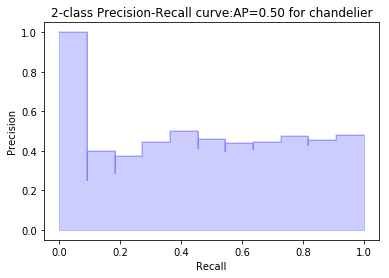

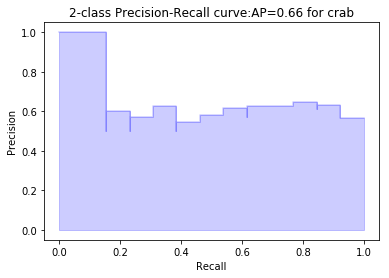

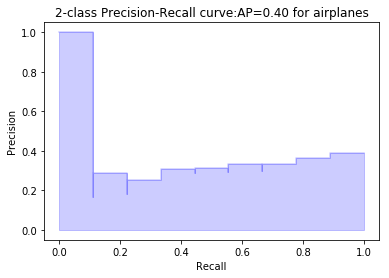

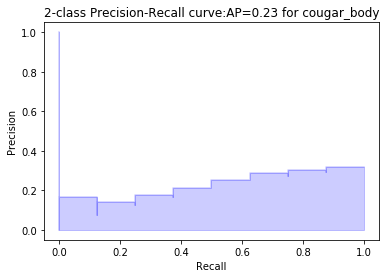

In [77]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

for y in range(5):
  y_true=[]  
  for x in scores:
    if x==mydirs[y]:
        y_true.append(x[0])
  y_scores=Y    

  #y_true=np.asarray(y_true)
  #y_scores=np.asarray(y_scores)    
  average_precision=average_precision_score(y_true, y_scores)  
  precision, recall, _ = precision_recall_curve(y_true, y_scores)

  plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('2-class Precision-Recall curve:AP={0:0.2f} for '.format(
          average_precision)+mydirs[y])
  plt.show()